## TITAN storm tracks

The storms are identified by “complex track” and “simple track” numbers.  Simple tracks have no “splits” or “mergers”.  Complex tracks consist of all tracks that are “connected” over the course of the event.  The files are organized chronologically by “complex track”.  The complex track number is in the second column and the simple track number is in the third column.  The first column contains the number of distinct “simple tracks” in the complex track.  The numbering of simple tracks is chronological.  The convention is that the complex track number and the simple track number are the same for the first simple track in the complex track.  Thus, complex track numbers do not necessarily have a unit increase from one complex track number to the next.  Time is given by Year, Month, Day, Hour, Min, Sec.  There are several representations of location.  Probably the best to work with are the Reflectivity Centroid Location (ReflCentroidLat and ReflCentroidLon in degrees ); we’ll also look at the Envelope centroid locations.  Useful representations of size and orientation are EnvelopeArea, EnvelopeOrientation, EnvelopeMajorRadius, EnvelopeMinorRadius.  “Convective Intensity” variables include Top, MaxDBZ and HtOfMaxDBZ.  “Cloud slope” is given by TiltAngle and TiltOrientation (lightning may be concentrated in the downslope portion of the cloud).  Motion is given either by Speed and Dirn or U and V.  Area > xx dBZ may be useful in summarizing time variation of aggregate storm properties.  Time rate of change variables include Dtop/Dt, DVolume/Dt and DdBZMax/Dt.

In [1]:
import pandas as pd
from pointprocess.plotting import *
from lightning_setup import *

%matplotlib inline

In [2]:
# the first thing I did was manually get rid of those last 3 rows of un-columned data
fname = '../../lightning/2012-08-19.txt'

In [3]:
f = open(fname)
header = f.readlines()[8].split(':')[1]
f.close()
header = [h.strip() for h in header.split(',')]

def dateparse(Y, m, d, H, M, S):
    d = pd.datetime(int(Y), int(m), int(d), int(H), int(M), int(S))
    return(d)

dates = ['Year', 'Month', 'Day', 'Hour', 'Min', 'Sec']
try:
    df = pd.read_csv(fname, skiprows=9, delim_whitespace=True, header=None, names=header, 
                     parse_dates={'date_time': dates}, date_parser=dateparse, index_col='date_time')
except:
    df = pd.read_csv(fname, skiprows=9, delim_whitespace=True, header=None, names=header)
    df[df.Sec.isnull()]

Some simple first comparisons to CG lightning:
 - map of [all storm locations](#Storm-locations) over terrain
 - map of storm locations with [Tops greater than 10 km](#Tops>10)
 - box plot of [storm speed](#Storm-speed)
 - [direction](#Direction) plot for all storm elements

## Storm locations

In [4]:
gb = df.groupby(df.ComplexNum)

In [5]:
storm_names = dict([(n[1], n[0]) for n in enumerate(df.ComplexNum.unique())])

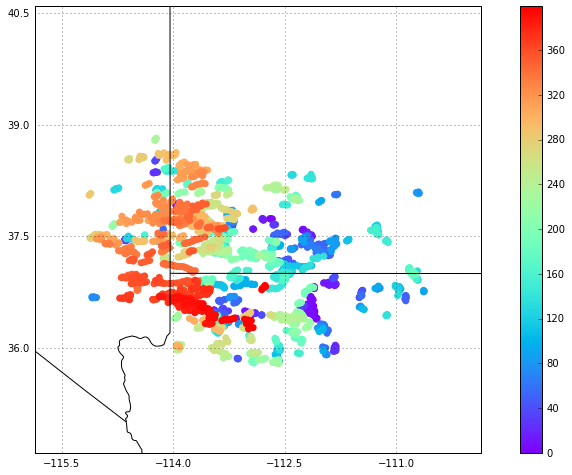

In [6]:
plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
background(ax)

df.plot.scatter(x='ReflCentroidLon(deg)', 
                y='ReflCentroidLat(deg)', 
                c=[storm_names[n] for n in df['ComplexNum']],
                ax=ax, cmap='rainbow',
                edgecolor='None', s=50)
# for k,v in gb.groups.items():
#     gb.get_group(k).plot(x='ReflCentroidLon(deg)', c='k',
#                          y='ReflCentroidLat(deg)', ax=ax, legend=None)
ax.set_extent([cities['cedar']['lon']-3, cities['cedar']['lon']+3,cities['cedar']['lat']-3, cities['cedar']['lat']+3])

## Tops>10

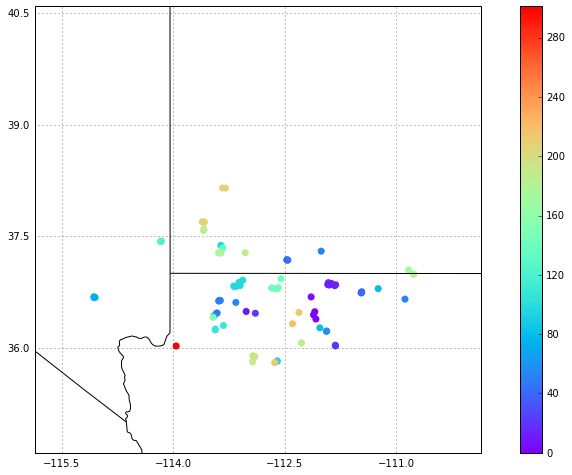

In [7]:
plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
background(ax)

df[df['Top(km)']>10].plot.scatter(x='ReflCentroidLon(deg)', 
                y='ReflCentroidLat(deg)', 
                c=[storm_names[n] for n in df[df['Top(km)']>10]['ComplexNum']],
                ax=ax, cmap='rainbow',
                edgecolor='None', s=50)
ax.set_extent([cities['cedar']['lon']-3, cities['cedar']['lon']+3,cities['cedar']['lat']-3, cities['cedar']['lat']+3])

## Storm speed

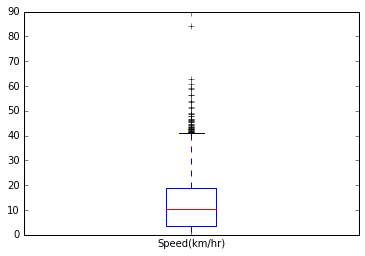

In [8]:
df['Speed(km/hr)'].plot.box();

## Direction
This one is a little tricky because at initiation the direction is set to zero, so we first need to get rid of all the zeros. Luckily we know that there are no actual zero values because 360 is included in the possible directions

In [9]:
def bearing_plot(df, N=16, bottom=0):
    ax = plt.subplot(111, polar=True)
    theta = np.linspace(0.0, 2 *np.pi, N, endpoint=False)
    radii, _ = np.histogram(df['Dirn(DegT)'][df['Dirn(DegT)']>0].values, bins=N)
    width = (2*np.pi) / N

    bars = ax.bar(theta, radii, width=width, bottom=bottom)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)

    # Use custom colors and opacity
    for r, bar in zip(radii, bars):
        bar.set_facecolor(plt.cm.jet(r/float(np.max(radii))))
        bar.set_alpha(0.8)
    return(ax)

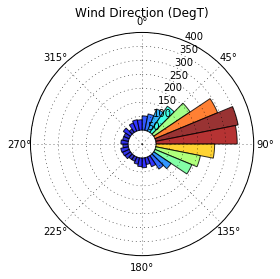

In [10]:
bearing_plot(df, N=32, bottom=50)
plt.title('Wind Direction (DegT)');